In [108]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import nltk
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sn

from text.process import text_processor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
    
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from keras.models import Sequential
from keras import layers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
from nltk.corpus import floresta

print(floresta.words())

['Um', 'revivalismo', 'refrescante', 'O', '7_e_Meio', ...]


In [2]:

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [96]:
RANDOM_STATE = 42
DATAFRAME_PATH = '/home/cti/workspace/cls_documento/dataset/output/dataframe.csv'


df = pd.read_csv(DATAFRAME_PATH)

# Remove documentos da parte técnica
df = df[ (df['tipo'] != 'Características técnicas') & (df['tipo'] != 'Planilha de orçamento - Ganhadora') & (df['tipo'] != 'Edital de classificação')] 

# df['tipo'] = df['tipo'].astype(str).apply(lambda x: x if x != 'Parecer Jurídico do Município' else 'Parecer Juridico minuta edital')
# df['tipo'] = df['tipo'].astype(str).apply(lambda x: x if x != 'Edital de classificação' else 'Edital de habilitação')

df.dropna()

df['texto'] = df['texto'].astype(str).apply(lambda x: x.replace("\n", " "))
df['texto_limpo'] = df['texto'].astype(str).apply(text_processor.clear_words)
df['texto_stemmed'] = df['texto_limpo'].astype(str).apply(text_processor.stem_sentence)
df['texto_len'] = df['texto'].astype(str).apply(len)
df['texto_limpo_len'] = df['texto_limpo'].astype(str).apply(len)
df['texto_stemmed_len'] = df['texto_stemmed'].astype(str).apply(len)
df['qtd_palavras_texto'] = df['texto'].apply(lambda x: len(str(x).split()))
df['qtd_palavras_texto_limpo'] = df['texto_limpo'].apply(lambda x: len(str(x).split()))
df['qtd_palavras_texto_stemmed'] = df['texto_stemmed'].apply(lambda x: len(str(x).split()))

df.sample(5)

Unnamed: 0                                    projeto  \
149         149             Goioxim - proj 41 - processo 1   
47           47          Carlópolis - proj 31 - processo 1   
12           12        Alto Paraíso - proj 39 - processo 1   
296         296  Santana do Itararé - proj 19 - processo 1   
212         212   Marilândia do Sul - proj 28 - processo 1   

                                                 texto  \
149  PREFEITURA MUNICIPAL DE GOIOXIM  ESTADO DO PAR...   
47   8 MUNICÍPIO DE CARLÓPOLIS diko  À ê 0 EDITAL D...   
12   Prefeitura Municipal de Alto Paraiso-PR CNPJ 9...   
296  PREFEITURA MUNICIPAL  SANTANA DO ITARARÉ  Depa...   
212  MUNICÍPIO MARILÂNDIA DO SUL  EDITAL DE HABILIT...   

                                             tipo  \
149  Publicações do aviso do Processo Licitatório   
47                 Edital do Processo Licitatório   
12             Relatórios do Processo Licitatório   
296            Relatórios do Processo Licitatório   
212                         Edital de habilitação   

                                           texto_limpo  \
149  prefeitura municipal goioxim estado paraná avi...   
47   município carlópolis diko edital pregao eletrô...   
12   prefeitura municipal alto paraiso-pr cnpj 640 ...   
296  prefeitura municipal santana itararé departame...   
212  município marilândia sul edital habilitação re...   

                                         texto_stemmed  texto_len  \
149  prefeit municip goioxim est paran avis licit e...      48415   
47   municípi carlópolil dik edit prega eletrôn 037...      53953   
12   prefeit municip alt paraiso-pr cnpj 640 736/00...       5245   
296  prefeit municip sant itararé departament munic...       9429   
212  municípi marilând sul edit habilit ref edit to...        868   

     texto_limpo_len  texto_stemmed_len  qtd_palavras_texto  \
149            36223              28016                7514   
47             39322              28188                7995   
12              3765               3035                 757   
296             6910               5674                1351   
212              634                485                 131   

     qtd_palavras_texto_limpo  qtd_palavras_texto_stemmed  
149                      4524                        4524  
47                       4378                        4378  
12                        490                         490  
296                       904                         904  
212                        75                          75

In [107]:
# encoder = LabelEncoder()
encoder = OneHotEncoder(sparse=False)
X = df.texto_limpo.values
# X = df.texto_stemmed.values
y = encoder.fit_transform(df.tipo.values.reshape(len(df.tipo.values), 1))

# vectorizer = CountVectorizer(token_pattern=r'\w{3,}')
# vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', ngram_range=(2,3), max_features=5000)
vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', max_features=5000)
vectorizer.fit( X )
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

input_dim = X_train.shape[1]

In [100]:

model = Sequential()
model.add(layers.Dense(16, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())


# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())

model.add(layers.Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 16)                80016     
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
dense_26 (Dense)             (None, 11)                187       
Total params: 80,267
Trainable params: 80,235
Non-trainable params: 32
_________________________________________________________________


In [101]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Train on 282 samples, validate on 71 samples
Epoch 1/50
282/282 [==============================] - 1s 3ms/step - loss: 2.1085 - acc: 0.3014 - val_loss: 2.3481 - val_acc: 0.5211
Epoch 2/50
282/282 [==============================] - 0s 153us/step - loss: 1.4146 - acc: 0.6631 - val_loss: 2.3049 - val_acc: 0.5493
Epoch 3/50
282/282 [==============================] - 0s 112us/step - loss: 1.1060 - acc: 0.7837 - val_loss: 2.2702 - val_acc: 0.6056
Epoch 4/50
282/282 [==============================] - 0s 162us/step - loss: 0.9714 - acc: 0.7837 - val_loss: 2.2457 - val_acc: 0.6056
Epoch 5/50
282/282 [==============================] - 0s 134us/step - loss: 0.8191 - acc: 0.8369 - val_loss: 2.2288 - val_acc: 0.6620
Epoch 6/50
282/282 [==============================] - 0s 160us/step - loss: 0.7734 - acc: 0.8333 - val_loss: 2.2107 - val_acc: 0.6761
Epoch 7/50
282/282 [==============================] - 0s 154us/step - loss: 0.7296 - acc: 0.8582 - val_loss: 2.1928 - val_acc: 0.6761
Epoch 8/50
282/282 

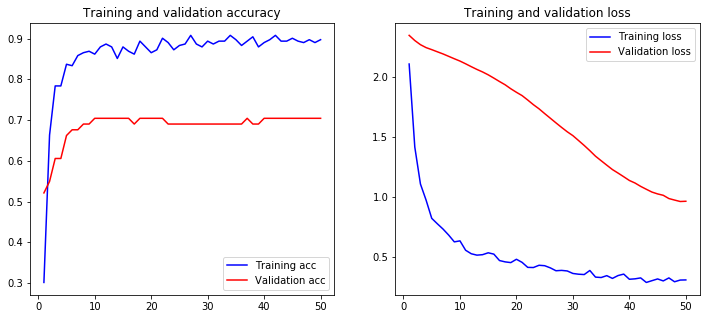

In [102]:
plot_history(history)

Acc Treino: 0.9078
Acc Teste:  0.7042


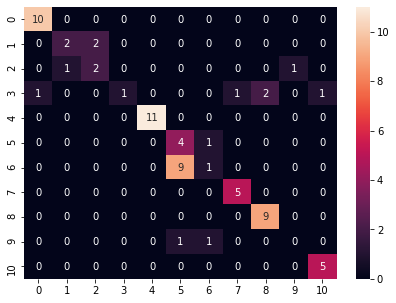

In [103]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Acc Treino: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Acc Teste:  {:.4f}".format(accuracy))


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


df_cm = pd.DataFrame(cm)
plt.figure(figsize = (7, 5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [105]:
index_test = 32
X_valid = df.iloc[index_test].texto_limpo
X_valid = vectorizer.transform([X_valid])

predicted = model.predict(X_valid)
print(predicted)
print(predicted.argmax(axis=-1))
print( encoder.inverse_transform(predicted) )
print(df.iloc[index_test].tipo)

[[0.00466228 0.00557293 0.00281016 0.00415373 0.00246174 0.00170048
  0.00165019 0.9659827  0.00249957 0.00334624 0.00516011]]
[7]
[['Portaria designando a comissão de licitação']]
Portaria designando a comissão de licitação


In [94]:

tipos = sorted(df.tipo.unique())

for tipo in sorted(tipos):
    print(tipo)
    encode = encoder.transform( np.array([tipo]).reshape(1, -1) )
    print(encode[0])


Atas do Processo Licitatório
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Declaração das proponentes declinando do prazo recursal
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Declaração de inexistência de recursos
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Edital de habilitação
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Edital do Processo Licitatório
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Parecer Juridico minuta edital
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Portaria designando a comissão de licitação
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Publicações do aviso do Processo Licitatório
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Recursos do Processo Licitatório
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Relatórios do Processo Licitatório
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
